## Event and Schedule classes

In [1]:
import heapq
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import random as random

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

## Queue and GroceryStore classes

In [6]:
class Queue:
    '''
    In this class we are storing a few distributions that are used to sample time values. 
    Further we also store some attributes specific to the queues such as number of people
    in the queue and being served
    '''

    def __init__(self, service_distribution, manager_distribution, queue_type, manager_queue=None):
    
        # Storing service and manager distributions as attributes
        self.service_distribution = service_distribution
        self.manager_distribution = manager_distribution
 
        # Keeping track of the number of people in the queue and number of people being served
        self.people_in_queue = 0
        self.people_being_served = 0
        self.total_customers = 0
        
        # Initializing the lists where we will store arrival 
        # and finishing times to compute waiting times
        self.arrival_times = []
        self.finishing_times = []
        
        # Adding an atribute that will specify the queue type
        self.queue_type = queue_type
        if queue_type == 'regular':
            self.manager_queue = manager_queue

    def add_customer(self, schedule):
        # Add the customer to the queue and adding the arrival time
        self.start_time = schedule.now
        self.arrival_times.append(schedule.now)
        # Recording changes and new customers
        self.people_in_queue += 1
        self.total_customers += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1

        # Depending on the type of the queues, different distributions will be sampled
        if self.queue_type == 'regular':
            schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer)
        else:
            schedule.add_event_after(
            self.manager_distribution.rvs(),
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        if self.queue_type == 'regular':
            # Modeling a 5% chance of the customer neediing a manager
            if random.random() < 0.05:
                schedule.add_event_after(0, self.manager_queue.add_customer)
        
        #recording the finishing times
        self.finishing_times.append(schedule.now)        
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)
        else:
            schedule.add_event_after(self.service_distribution.rvs(), self.add_customer)


class GroceryStore:
    '''
    In this class we are definding the main method that sends customers to queues. It also stores distributions 
    and the list of queues
    '''
    def __init__(self, arrival_distribution, num_of_queues):
        # Creating a list where we will record the number of people in a queue at any given time
        self.plotting_data = {"time" :[], "num_in_queue" : []}
        # Creating a list of queues and a manager queue
        self.queue_list = []
        self.manager_queue = Queue(service_distribution, manager_distribution, queue_type = 'manager')
        for i in range(num_of_queues):
            self.queue_list.append(Queue(service_distribution, manager_distribution, queue_type = 'regular', manager_queue=self.manager_queue))
        #specifying the arrival distribution
        self.arrival_distribution = arrival_distribution
    
    def add_customer(self, schedule):
        # Add this customer to the queue
        self.shortest_queue = self.queue_list[0]
        # Creating a large number
        i = float('inf')
        # Finding the shortest queue
        for l in self.queue_list:
            if l.people_in_queue < i:
                i = l.people_in_queue
                self.shortest_queue = l
        # Adding a customer to the shortest queuue
        self.shortest_queue.add_customer(schedule)
        # Recording the number of people in the shortest queue
        self.plotting_data["time"].append(schedule.now)
        self.plotting_data["num_in_queue"].append(self.queue_list[0].people_in_queue)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
      
    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_distribution, service_distribution, manager_distribution, run_until, num_of_queues):
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_distribution, num_of_queues)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()

    return grocery_store

# Run an M/G/1 simulation

In [7]:
#here we set the duration of the simulation and the number of queues
duration = 540
num_of_queues = 2

# Exponential with lambda = 1
arrival_distribution = sts.expon(scale=1/1)

# Normal with mu = 3 and sigma = 1
service_distribution = sts.norm(loc=3, scale=1)

# Normal with mu = 4 and sigma = 1
manager_distribution = sts.norm(loc=4, scale=1)

grocery_store = run_simulation(arrival_distribution, service_distribution, manager_distribution, duration, num_of_queues)

87
88


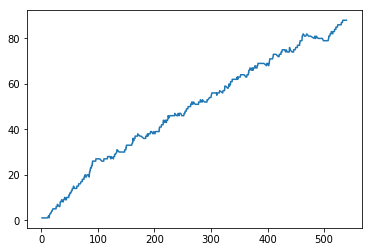

In [1175]:
#printing the number of people in different queues
for i in range(len(grocery_store.queue_list)):
    print(grocery_store.queue_list[i].people_in_queue)
grocery_store.manager_queue.people_in_queue

#plotting the number of people in the longest queue at different times
plt.plot(grocery_store.plotting_data["time"],grocery_store.plotting_data["num_in_queue"])

In [1176]:
# Total number of people in each queue
for i in range(len(grocery_store.queue_list)):
    print('The overall number of people that have joined queue', i, 'is:', grocery_store.queue_list[i].total_customers)
print('The overall number of people that have joined the manager queue is:',grocery_store.manager_queue.total_customers)

The overall number of people that have joined queue 0 is: 274
The overall number of people that have joined queue 1 is: 268
The overall number of people that have joined the manager queue is: 88


In [1177]:
'''
This function returns two things: 1. The plot with the expected average waiting times in different queueus
with 95% confidence intervals; 2. The expected value of the largest queue length in the largest queue 
of the grocery store (the first queue, since we are always checking it first). It takes two parameters:
n (# of times we want to run the simulation) and q (# of queues)

NOTE: in lines 21-22 I am accounting for the fact that after simulation ends, some people who entered
the queue are never reaching the cashier because of the interruption. This is happening because I did 
not manage to implement the rule that store closes at 6 and everyone left in the queue is served. However
I found a way to still calculate waiting times by finding the different between the lnegths of the 
arrival times list and the finishing times list and then cutting the former one by this difference 
which means that the people who joined the queue but did not finish are not taken into account.
'''

def info(n, q):
    #initializing all of the lists
    waiting_times = [[] for _ in range(q)]
    waiting_times_means = []
    waiting_times_conf_ints = []
    max_queue_lengths = []
    manager_count = []

    for k in range(n):
        grocery_store = run_simulation(arrival_distribution, service_distribution, manager_distribution, duration, q)
        for i in range(q):
            diff = len(grocery_store.queue_list[i].arrival_times) - len(grocery_store.queue_list[i].finishing_times)
            grocery_store.queue_list[i].arrival_times = grocery_store.queue_list[i].arrival_times[0:(len(grocery_store.queue_list[i].arrival_times)-diff)]
        
        #adding all necessary values to the lists here
        for i in range(len(waiting_times)):
            waiting_times[i].append(np.mean(np.array(grocery_store.queue_list[i].finishing_times)-np.array(grocery_store.queue_list[i].arrival_times)))
        max_queue_lengths.append(max(grocery_store.plotting_data["num_in_queue"]))
        manager_count.append(grocery_store.manager_queue.total_customers)
        
    for i in range(q):
        waiting_times_means.append(np.mean(waiting_times[i]))
        waiting_times_conf_ints.append([np.percentile(waiting_times[i], 2.5), np.percentile(waiting_times[i], 97.5)])
    
    return waiting_times_means, waiting_times_conf_ints, max_queue_lengths, manager_count


In [1178]:
#plotting data
#creating different lists for y values and error bars

x = np.linspace(1,10,10)
y = []
y_err = []
y1 = []
y1_err = []
y2 = []
y2_err = []

for i in range(1,11):
    a = info(10, i)
    y.append(a[0][0])
    y_err.append(a[1][0][1]-a[1][0][0])
    y1.append(np.mean(a[2]))
    y1_err.append(np.percentile(a[2], 97.5)-np.percentile(a[2], 2.5))
    y2.append(np.mean(a[3]))
    y2_err.append(np.percentile(a[3], 97.5)-np.percentile(a[3], 2.5))
    
    print('For', i, 'queue(s), the expected value of the average waiting time is', round(a[0][0], 2),
          'with a 95% confidence interval:', [round(a[1][0][0], 2), round(a[1][0][1], 2)])
    print('For', i, 'queue(s), the expected value of the maximum queue length is', round(np.mean(a[2]), 2),
         'with a 95% confidence interval:', [np.percentile(a[2], 2.5), np.percentile(a[2], 97.5)])
    print('___________________')

For 1 queue(s), the expected value of the average waiting time is 178.5 with a 95% confidence interval: [172.4, 188.42]
For 1 queue(s), the expected value of the maximum queue length is 358.4 with a 95% confidence interval: [319.625, 383.3]
___________________
For 2 queue(s), the expected value of the average waiting time is 95.45 with a 95% confidence interval: [75.33, 108.77]
For 2 queue(s), the expected value of the maximum queue length is 95.9 with a 95% confidence interval: [78.45, 110.97500000000001]
___________________
For 3 queue(s), the expected value of the average waiting time is 18.62 with a 95% confidence interval: [8.28, 35.07]
For 3 queue(s), the expected value of the maximum queue length is 12.1 with a 95% confidence interval: [5.675, 22.975]
___________________
For 4 queue(s), the expected value of the average waiting time is 6.33 with a 95% confidence interval: [5.7, 6.88]
For 4 queue(s), the expected value of the maximum queue length is 3.2 with a 95% confidence inte

/Users/nazaryaremko/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nazaryaremko/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nazaryaremko/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


For 8 queue(s), the expected value of the average waiting time is 5.23 with a 95% confidence interval: [4.99, 5.44]
For 8 queue(s), the expected value of the maximum queue length is 2.0 with a 95% confidence interval: [2.0, 2.0]
___________________
For 9 queue(s), the expected value of the average waiting time is 5.22 with a 95% confidence interval: [5.01, 5.47]
For 9 queue(s), the expected value of the maximum queue length is 2.0 with a 95% confidence interval: [2.0, 2.0]
___________________
For 10 queue(s), the expected value of the average waiting time is 5.19 with a 95% confidence interval: [4.97, 5.43]
For 10 queue(s), the expected value of the maximum queue length is 2.0 with a 95% confidence interval: [2.0, 2.0]
___________________


Text(0,0.5,'Average waiting time (minutes)')

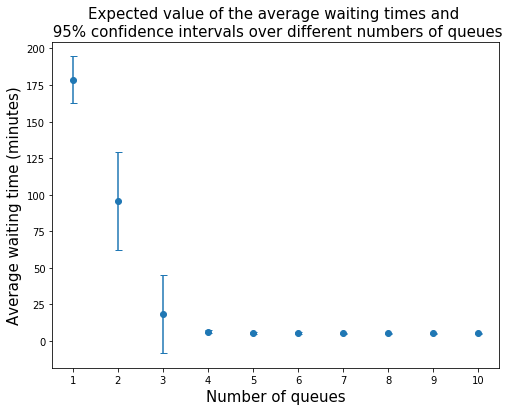

In [1179]:
plt.figure(figsize=(8, 6))
plt.errorbar(x,y,y_err, fmt='o', capsize=3.5)
plt.xticks(np.linspace(1,10,10))
plt.title('Expected value of the average waiting times and \n 95% confidence intervals over different numbers of queues', size=15)
plt.xlabel('Number of queues', size=15)
plt.ylabel('Average waiting time (minutes)', size=15)

Text(0,0.5,'Average maximum queue length')

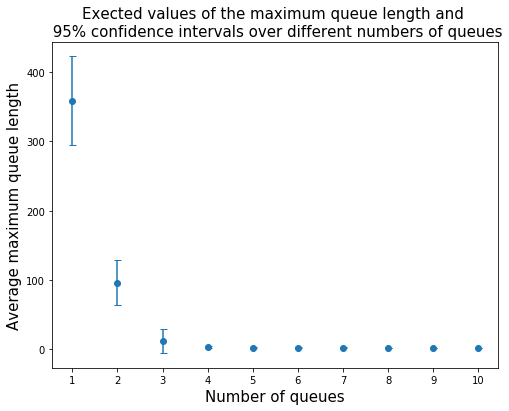

In [1185]:
plt.figure(figsize=(8, 6))
plt.errorbar(x,y1,y1_err, fmt='o', capsize=3.5)
plt.xticks(np.linspace(1,10,10))
plt.title('Exected values of the maximum queue length and \n 95% confidence intervals over different numbers of queues', size=15)
plt.xlabel('Number of queues', size=15)
plt.ylabel('Average maximum queue length', size=15)

Text(0,0.5,' Average number of customers')

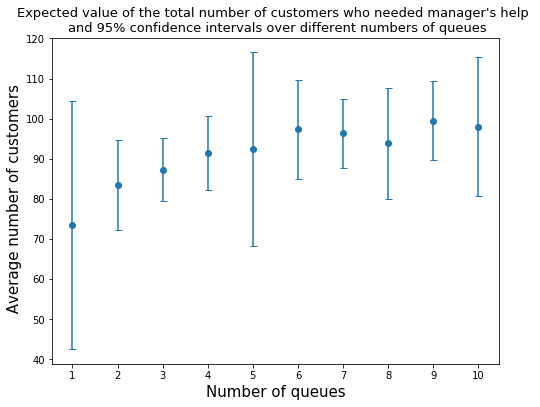

In [1184]:
plt.figure(figsize=(8, 6))
plt.errorbar(x,y2,y2_err, fmt='o', capsize=3.5)
plt.xticks(np.linspace(1,10,10))
plt.title("Expected value of the total number of customers who needed manager's help \n and 95% confidence intervals over different numbers of queues", size=13)
plt.xlabel('Number of queues', size=15)
plt.ylabel(' Average number of customers', size=15)

In [1182]:
# Calculating theoretical values
tau = 3
sigma = 1
theoretical_waiting_averages = []
for i in range(4,11):
    lamb = 1/i
    rho = lamb*tau
    theoretical_waiting_averages.append(round(rho**2 / 2 / (1-rho) * (1 + sigma**2 / tau**2),3))
    print("Theoretical average waiting time for", i, "queues at equilibrium is", round(rho**2 / 2 / (1-rho) * (1 + sigma**2 / tau**2),3))
    print("_____")



Theoretical average waiting time for 4 queues at equilibrium is 1.25
_____
Theoretical average waiting time for 5 queues at equilibrium is 0.5
_____
Theoretical average waiting time for 6 queues at equilibrium is 0.278
_____
Theoretical average waiting time for 7 queues at equilibrium is 0.179
_____
Theoretical average waiting time for 8 queues at equilibrium is 0.125
_____
Theoretical average waiting time for 9 queues at equilibrium is 0.093
_____
Theoretical average waiting time for 10 queues at equilibrium is 0.071
_____


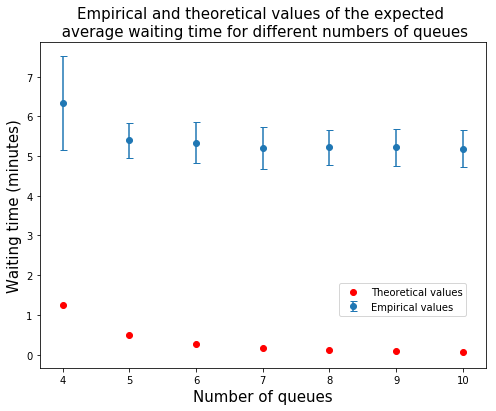

In [1183]:
plt.figure(figsize=(8, 6))
plt.errorbar(x[3:],y[3:],y_err[3:], fmt='o', capsize=3.5, label='Empirical values')
plt.scatter(x[3:],theoretical_waiting_averages, color='red', label='Theoretical values')
plt.title("Empirical and theoretical values of the expected \n average waiting time for different numbers of queues", size=15)
plt.xlabel('Number of queues', size=15)
plt.ylabel('Waiting time (minutes)', size=15)
plt.legend(loc=(0.67,0.16))